In [1]:
# !pip install tensorflow_datasets

In [2]:
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Convolution2D, MaxPooling2D, Activation, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.nasnet import NASNetMobile

from sklearn.metrics import classification_report
tf.__version__

'2.0.1'

In [3]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
#     tf.compat.v1.disable_eager_execution()
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [4]:
%%time
(train_ds, test_ds, valid_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]', 'validation'],
)

CPU times: user 1.54 s, sys: 1.2 s, total: 2.74 s
Wall time: 2.17 s


In [5]:
ds_info.splits

{'train': <tfds.core.SplitInfo num_examples=75750>,
 'validation': <tfds.core.SplitInfo num_examples=25250>}

In [6]:
class_names = ds_info.features['label'].names
str(class_names)

"['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_so

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
TRAIN_DATA_SIZE = int(ds_info.splits['train'].num_examples * 0.9)
TEST_DATA_SIZE = ds_info.splits['train'].num_examples - TRAIN_DATA_SIZE
VALID_DATA_SIZE = ds_info.splits['validation'].num_examples
IMAGE_SHAPE = (299, 299, 3)
# IMAGE_SHAPE = (224, 224, 3)
EPOCHS = 50

In [8]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

In [9]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label

def convert_and_resize(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_pad(image, IMAGE_SHAPE[0], IMAGE_SHAPE[1]) # Add 6 pixels of padding
    return image, label


def augment(image,label):
#     image,label = convert(image, label)
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_pad(image, IMAGE_SHAPE[0]+25, IMAGE_SHAPE[1]+25) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=IMAGE_SHAPE) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.4) # Random brightness
    image = tf.image.random_flip_left_right(image)
    return image,label

In [10]:
# sample = next(iter(train_ds))
# visualize(sample[0], augment(sample[0], sample[1])[0])

In [11]:
augmented_train_batches = (
    train_ds
#     .take(1616)
#     .shuffle(buffer_size=TRAIN_DATA_SIZE, reshuffle_each_iteration=True)
    .shuffle(buffer_size=5000, reshuffle_each_iteration=True)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .repeat(EPOCHS)
    .prefetch(AUTOTUNE)
)

In [12]:
non_augmented_test_batches = (
    test_ds
#     .take(196)
#     .shuffle(buffer_size=TEST_DATA_SIZE, reshuffle_each_iteration=True)
    .shuffle(buffer_size=5000, reshuffle_each_iteration=True)
    # No augmentation.
    .map(convert_and_resize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .repeat(EPOCHS)
    .prefetch(AUTOTUNE)
)

In [13]:
non_augmented_validation_batches = (
    valid_ds
#     .take(22*BATCH_SIZE)
#     .shuffle(buffer_size=VALID_DATA_SIZE, reshuffle_each_iteration=True)
    .shuffle(buffer_size=5000, reshuffle_each_iteration=True)
    .map(convert_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat(EPOCHS)
    .batch(2*BATCH_SIZE, drop_remainder=True)
)

In [14]:
def make_model(weights='imagenet', base_model_trainable=True):
    inputs = Input(shape=IMAGE_SHAPE, name="Input")

# InceptionResNetV2
    base_model = InceptionResNetV2(include_top=False, 
                               input_shape=IMAGE_SHAPE, 
                               input_tensor=inputs, 
                               weights=weights, 
                               classes=len(class_names))
    
# VGG16
#     base_model = VGG16(include_top=False,
#                       input_shape=IMAGE_SHAPE,
#                       input_tensor=inputs,
#                       weights=weights,
#                       classes=len(class_names))

# ResNet50V2
#     base_model = ResNet50V2(include_top=False,
#                   input_shape=IMAGE_SHAPE,
#                   input_tensor=inputs,
#                   weights=weights,
#                   classes=len(class_names))
    
# NASNetMobile
#     base_model = NASNetMobile(include_top=False,
#               input_shape=IMAGE_SHAPE,
#               input_tensor=inputs,
#               weights=weights,
#               classes=len(class_names))
    
#     base_model.trainable = False
    base_model.trainable = base_model_trainable
#     batch_norm1 = BatchNormalization()(base_model.output)
#     flat1 = Flatten()(batch_norm1)
#     dense_1 = Dense(100, activation="relu")(flat1)
    
    wd = tf.keras.regularizers.l2(0.001)

    global_avg_pooling = GlobalAveragePooling2D()(base_model.output)
    drop_0 = Dropout(0.2)(global_avg_pooling)
    dense_1 = Dense(2048, activation="relu", kernel_regularizer=wd)(drop_0)
    drop_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(4096, activation="relu", kernel_regularizer=wd)(drop_1)
    drop_2 = Dropout(0.4)(dense_2)
    dense_3 = Dense(1024, activation="relu", kernel_regularizer=wd)(drop_2)
    drop_3 = Dropout(0.3)(dense_3)
    dense_4 = Dense(len(class_names), activation="softmax")(drop_3)

    model = Model(inputs=[inputs], outputs=[dense_4])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [15]:
try:
    del model
    K.clear_session()
except:
    pass
model = make_model(base_model_trainable=False)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

block17_6 (Lambda)              (None, 17, 17, 1088) 0           block17_5_ac[0][0]               
                                                                 block17_6_conv[0][0]             
__________________________________________________________________________________________________
block17_6_ac (Activation)       (None, 17, 17, 1088) 0           block17_6[0][0]                  
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 17, 17, 128)  139264      block17_6_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 17, 17, 128)  384         conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_101 (Activation)     (None, 17, 17, 128)  0           batch_normalization_101[0][0]    
__________

Total params: 70,176,069
Trainable params: 15,839,333
Non-trainable params: 54,336,736
__________________________________________________________________________________________________


In [ ]:
history = model.fit(augmented_train_batches, epochs=EPOCHS, validation_data=non_augmented_validation_batches, steps_per_epoch=TRAIN_DATA_SIZE//BATCH_SIZE, validation_steps=10)
# history = model.fit(augmented_train_batches, epochs=EPOCHS, validation_data=non_augmented_validation_batches, steps_per_epoch=1616//BATCH_SIZE, validation_steps=2)

Train for 266 steps, validate for 10 steps
Epoch 1/50
266/266 [==============================] - 622s 2s/step - loss: 4.8193 - accuracy: 0.1750 - val_loss: 3.4019 - val_accuracy: 0.2908
Epoch 2/50
266/266 [==============================] - 595s 2s/step - loss: 3.3315 - accuracy: 0.2992 - val_loss: 3.0396 - val_accuracy: 0.3434
Epoch 3/50
266/266 [==============================] - 590s 2s/step - loss: 3.1680 - accuracy: 0.3316 - val_loss: 3.0292 - val_accuracy: 0.3535
Epoch 4/50
266/266 [==============================] - 589s 2s/step - loss: 3.0942 - accuracy: 0.3482 - val_loss: 3.0624 - val_accuracy: 0.3562
Epoch 5/50
266/266 [==============================] - 588s 2s/step - loss: 3.0553 - accuracy: 0.3570 - val_loss: 2.9973 - val_accuracy: 0.3840
Epoch 6/50
266/266 [==============================] - 589s 2s/step - loss: 3.0366 - accuracy: 0.3611 - val_loss: 2.9678 - val_accuracy: 0.3768
Epoch 7/50
266/266 [==============================] - 589s 2s/step - loss: 3.0124 - accuracy: 0.368

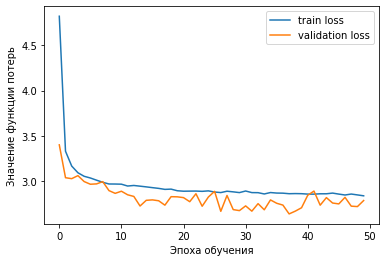

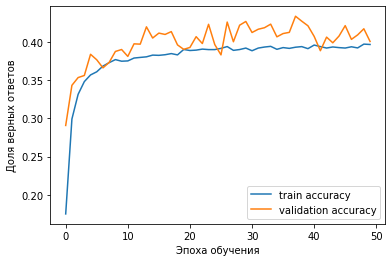

In [26]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [27]:
def test_item(sample):
    prediction = model.predict(sample[None, ...])[0]
    ans = np.argmax(prediction)

    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1,2,1)
    ax.imshow(sample)
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1,2,2)
    bar_list = ax.bar(np.arange(len(class_names)), prediction, align="center")
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xlim([-1, len(class_names)])
    ax.grid(True)

    plt.show()

    print("Predicted: %d - %s" % (ans, class_names[ans]))

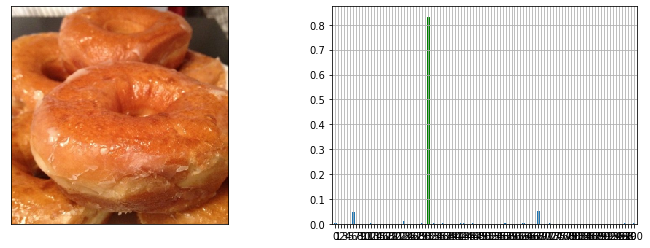

Predicted: 31 - donuts
True answer: 31 - donuts


In [28]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

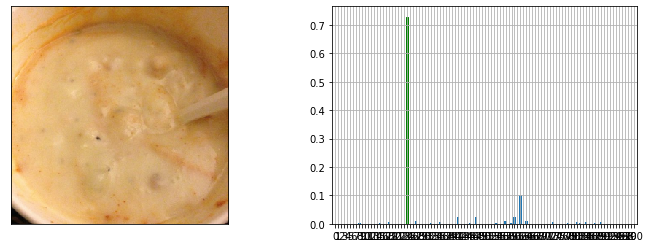

Predicted: 24 - clam_chowder
True answer: 24 - clam_chowder


In [29]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

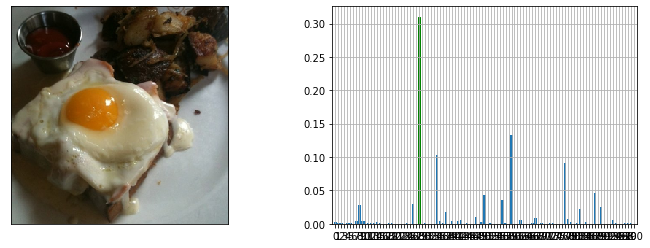

Predicted: 28 - croque_madame
True answer: 28 - croque_madame


In [30]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

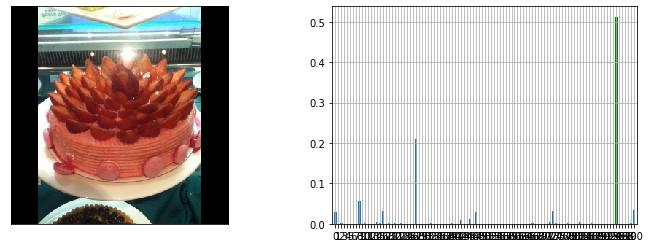

Predicted: 94 - strawberry_shortcake
True answer: 94 - strawberry_shortcake


In [31]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

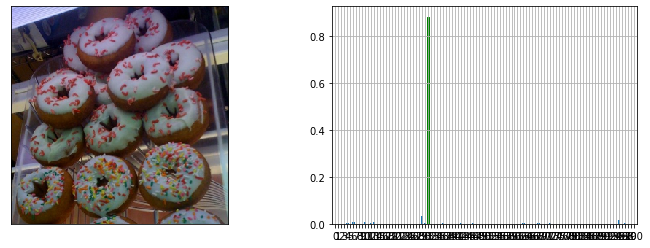

Predicted: 31 - donuts
True answer: 31 - donuts


In [32]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

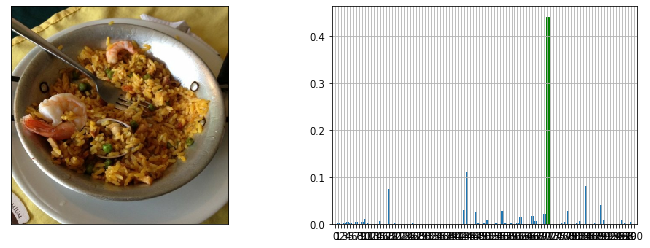

Predicted: 71 - paella
True answer: 71 - paella


In [33]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

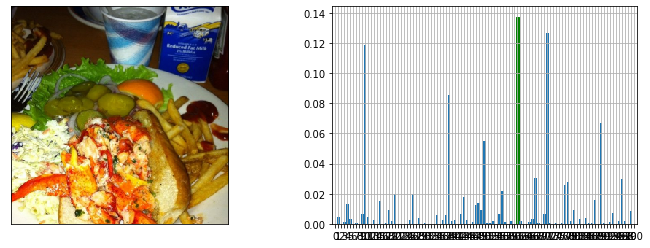

Predicted: 61 - lobster_roll_sandwich
True answer: 61 - lobster_roll_sandwich


In [34]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

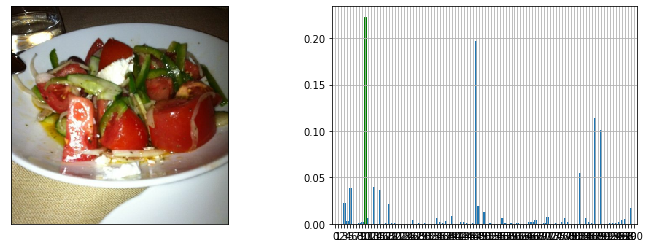

Predicted: 10 - bruschetta
True answer: 48 - greek_salad


In [35]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))

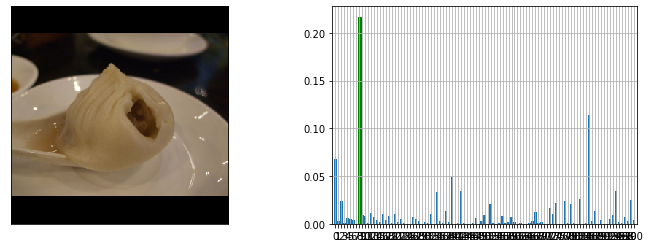

Predicted: 8 - bread_pudding
True answer: 32 - dumplings


In [36]:
sample = next(iter(non_augmented_validation_batches))
test_item(sample[0][0])

print("True answer: %d - %s" % (sample[1][0], class_names[sample[1][0]]))